In [2]:
import numpy as np
import scipy.stats
import math as math
import autograd.numpy as np
from autograd import grad, jacobian
from scipy import optimize
import pandas as pd

In [3]:
s_list = [5.22, 9.79, 23.66]
L = 10
m = 3

In [4]:
cov_list = [[[s_list[i] * np.exp(-(k - j)**2 / (2 * L**2)) for k in range(m)]
             for j in range(m)] for i in range(3)]

In [5]:
x = np.random.multivariate_normal(
    -5 * np.ones(m), cov_list[0]).tolist() + np.random.multivariate_normal(
        -10 * np.ones(m),
        cov_list[1]).tolist() + np.random.multivariate_normal(
            -15 * np.ones(m), cov_list[2]).tolist()
t = np.exp(x)
A = np.random.rand(3 * m, 3 * m)

In [6]:
def gomos(t):
    global A
    return np.array([np.exp(-i) for i in A.dot(t)])


def gomos_noise(t, noise):
    return np.exp(-A.dot(t)) + noise


def MAP(t, y):
    return np.linalg.norm(gomos(t) - y)


jacobian_gomos = jacobian(gomos)

In [7]:
origin_noise = np.random.normal(0, 0.012, 3 * m)
y = gomos_noise(t, origin_noise)

In [130]:
np.round(y, 3)

array([0.989, 0.988, 1.001, 0.992, 1.005, 0.997, 0.982, 1.004, 0.991])

In [128]:
output = ''
for i in A:
    output = output + str(np.round(i[0], 3))
    for j in i[1:]:
        output = output + '&' + str(np.round(j, 3))
    output = output + '\\'
output

'0.141&0.979&0.002&0.182&0.496&0.582&0.259&0.681&0.639\\0.262&0.646&0.618&0.086&0.616&0.378&0.781&0.855&0.177\\0.934&0.589&0.418&0.925&0.542&0.154&0.33&0.42&0.343\\0.937&0.853&0.254&0.223&0.408&0.399&0.327&0.606&0.708\\0.703&0.923&0.618&0.482&0.899&0.891&0.446&0.001&0.982\\0.808&0.274&0.813&0.194&0.853&0.209&0.088&0.978&0.633\\0.051&0.385&0.78&0.386&0.237&0.269&0.975&0.999&0.977\\0.578&0.935&0.81&0.232&0.056&0.525&0.187&0.83&0.718\\0.049&0.69&0.72&0.989&0.316&0.153&0.554&0.428&0.934\\'

In [8]:
optim = optimize.minimize(MAP, x0=np.random.normal(0, 1, 3 * m), args=(y))
Q = np.linalg.qr(jacobian_gomos(optim.x))[0]

In [9]:
def MAP_noise(t, y, Q, noise):
    return (np.linalg.norm(Q.transpose().dot(gomos(t) - (y + noise))))**2


def c(t, y, Q):
    return abs(np.linalg.det(Q.transpose().dot(jacobian_gomos(t)))) * math.exp(
        0.5 * np.linalg.norm(gomos(t) - y)**2 -
        0.5 * np.linalg.norm(Q.transpose().dot(gomos(t) - y))**2)

In [54]:
%%time
sample = pd.DataFrame(
    columns=['s11', 's12', 's13', 's21', 's22', 's23', 's31', 's32', 's33'])
temp = 0.001 * np.ones(3 * m)
while len(sample) < 2 * 10e3:
    optim_fun = 1
    while optim_fun >= 10e-8:
        curr_noise = np.random.normal(0, 0.05, 3 * m)
        optim1 = optimize.minimize(MAP_noise,
                                   x0=optim.x,
                                   args=(y, Q, curr_noise),
                                   tol=10e-16)
        optim_fun = optim1.fun
    candid = optim1.x
    r = np.random.uniform(0, 1)
    # print(candid)
    # print(temp)
    p = c(temp, y, Q) / (c(candid, y, Q))
    # print(c(temp,y,Q))
    if r < p:
        sample = sample.append(
            pd.DataFrame([candid.tolist()], columns=sample.columns))
        temp = candid
    else:
        sample = sample.append(
            pd.DataFrame([temp.tolist()], columns=sample.columns))
    # print(sample)

C:\Users\Xinyuan Niu\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
C:\Users\Xinyuan Niu\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
C:\Users\Xinyuan Niu\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Wall time: 26min 7s


In [98]:
sample = sample.set_index(pd.Series([i for i in range(20000)]))
sample.to_csv('GOMOS.csv')

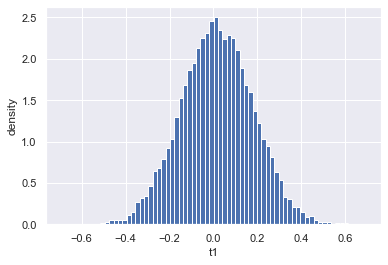

In [93]:
import matplotlib.pyplot as plt
p = plt.hist(sample.s12, bins=70, density=True)
plt.xlabel('t1')
plt.ylabel('density')
plt.show(p)

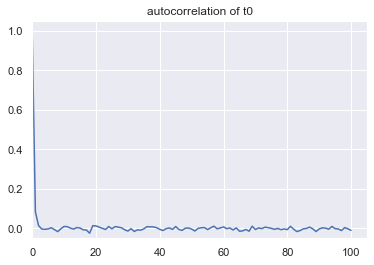

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf

plt.plot(acf(sample.s11, nlags=100, fft=False))
plt.title('autocorrelation of t0')
plt.xlim(0, None)
plt.ylim(-0.05, None)
plt.show()

Wall time: 5min 14s


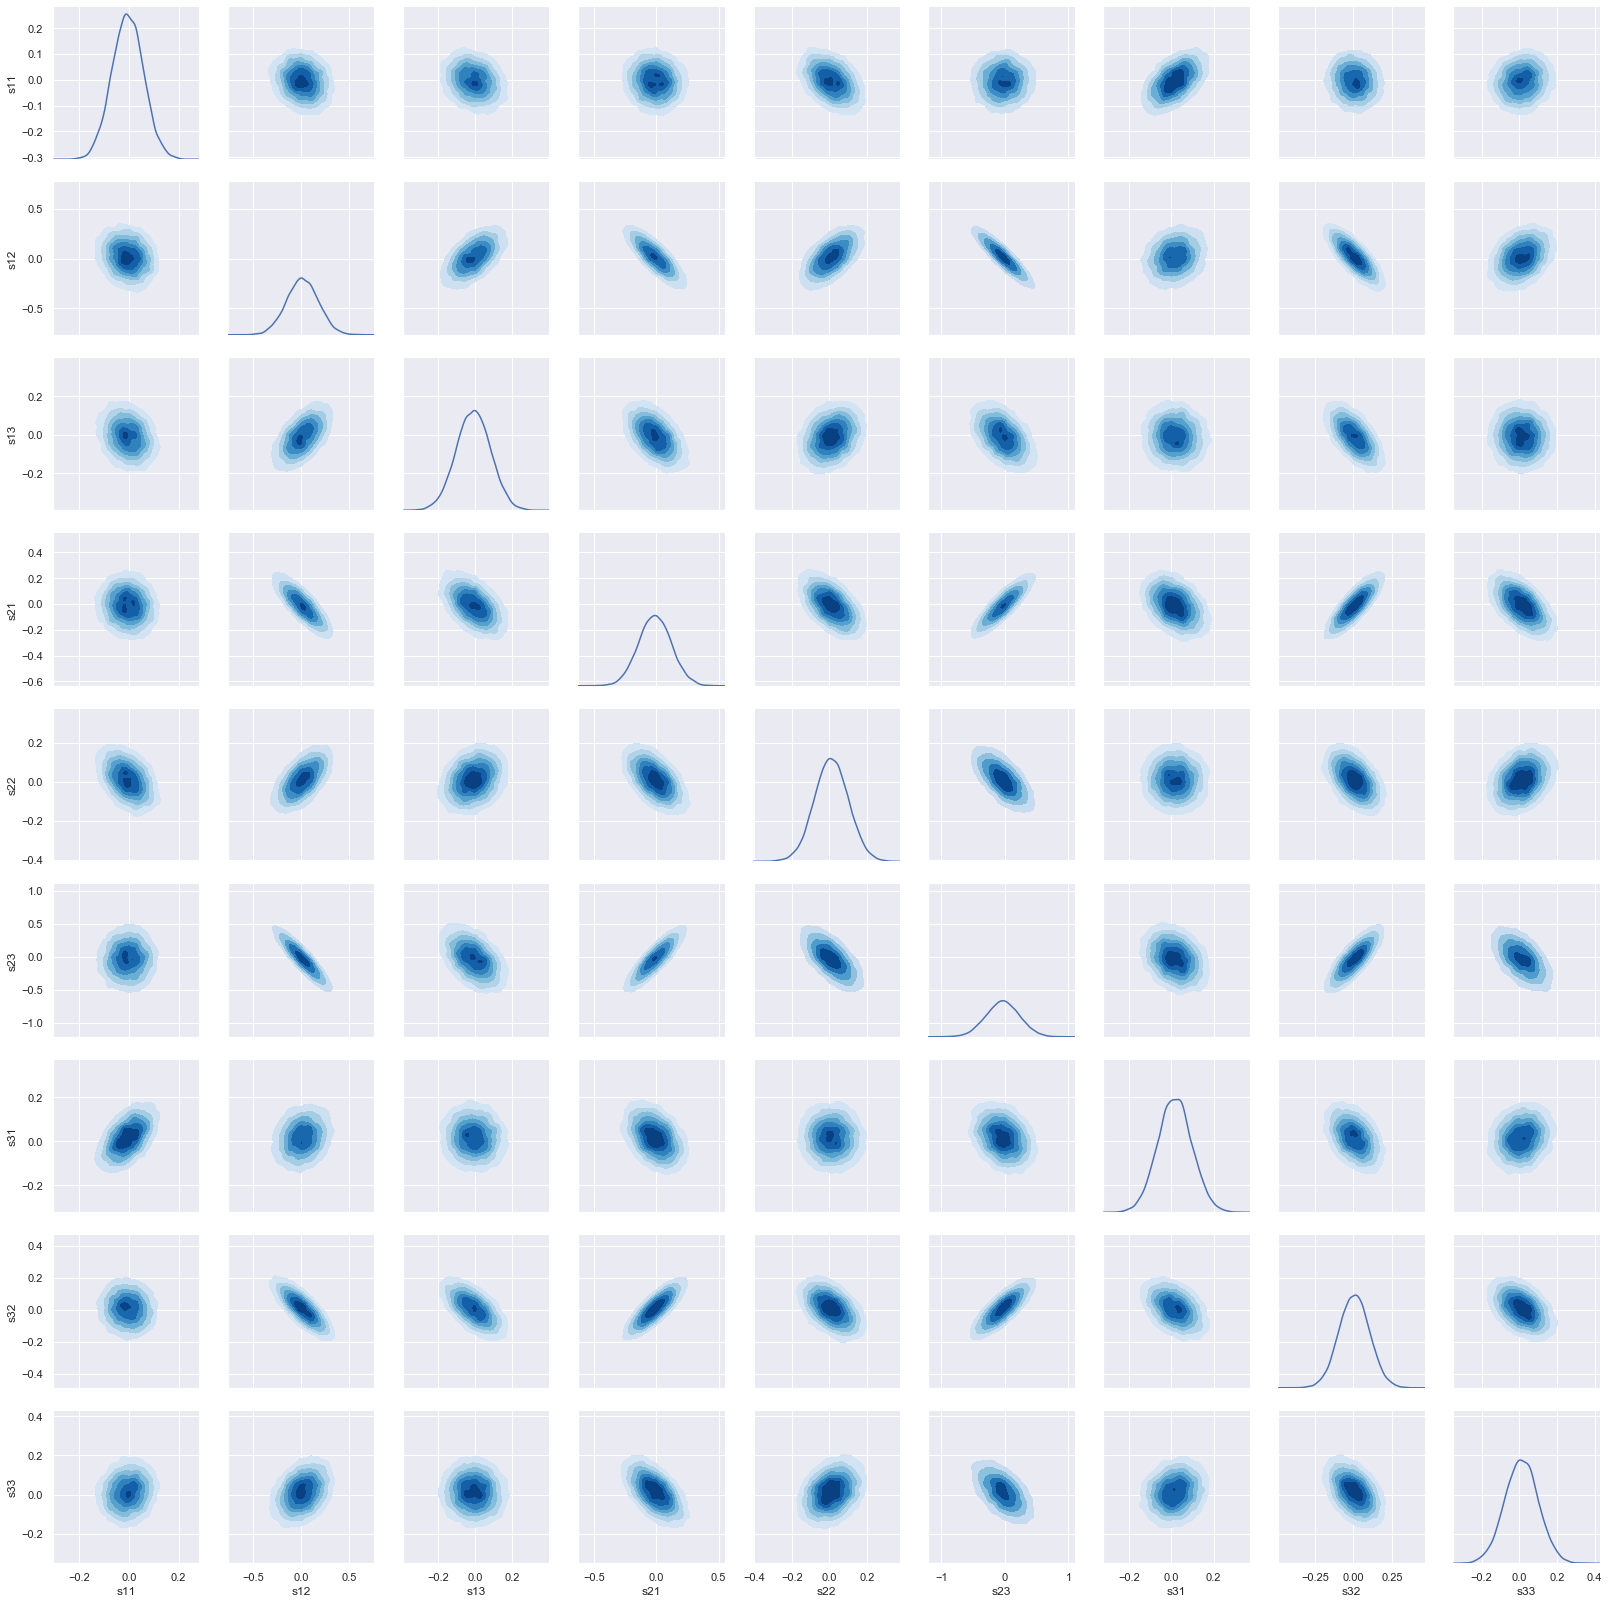

In [84]:
%%time
sns.set(color_codes=True)
g = sns.PairGrid(sample)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot,
              n_levels=7,
              cmap="Blues",
              shade=True,
              shade_lowest=False)

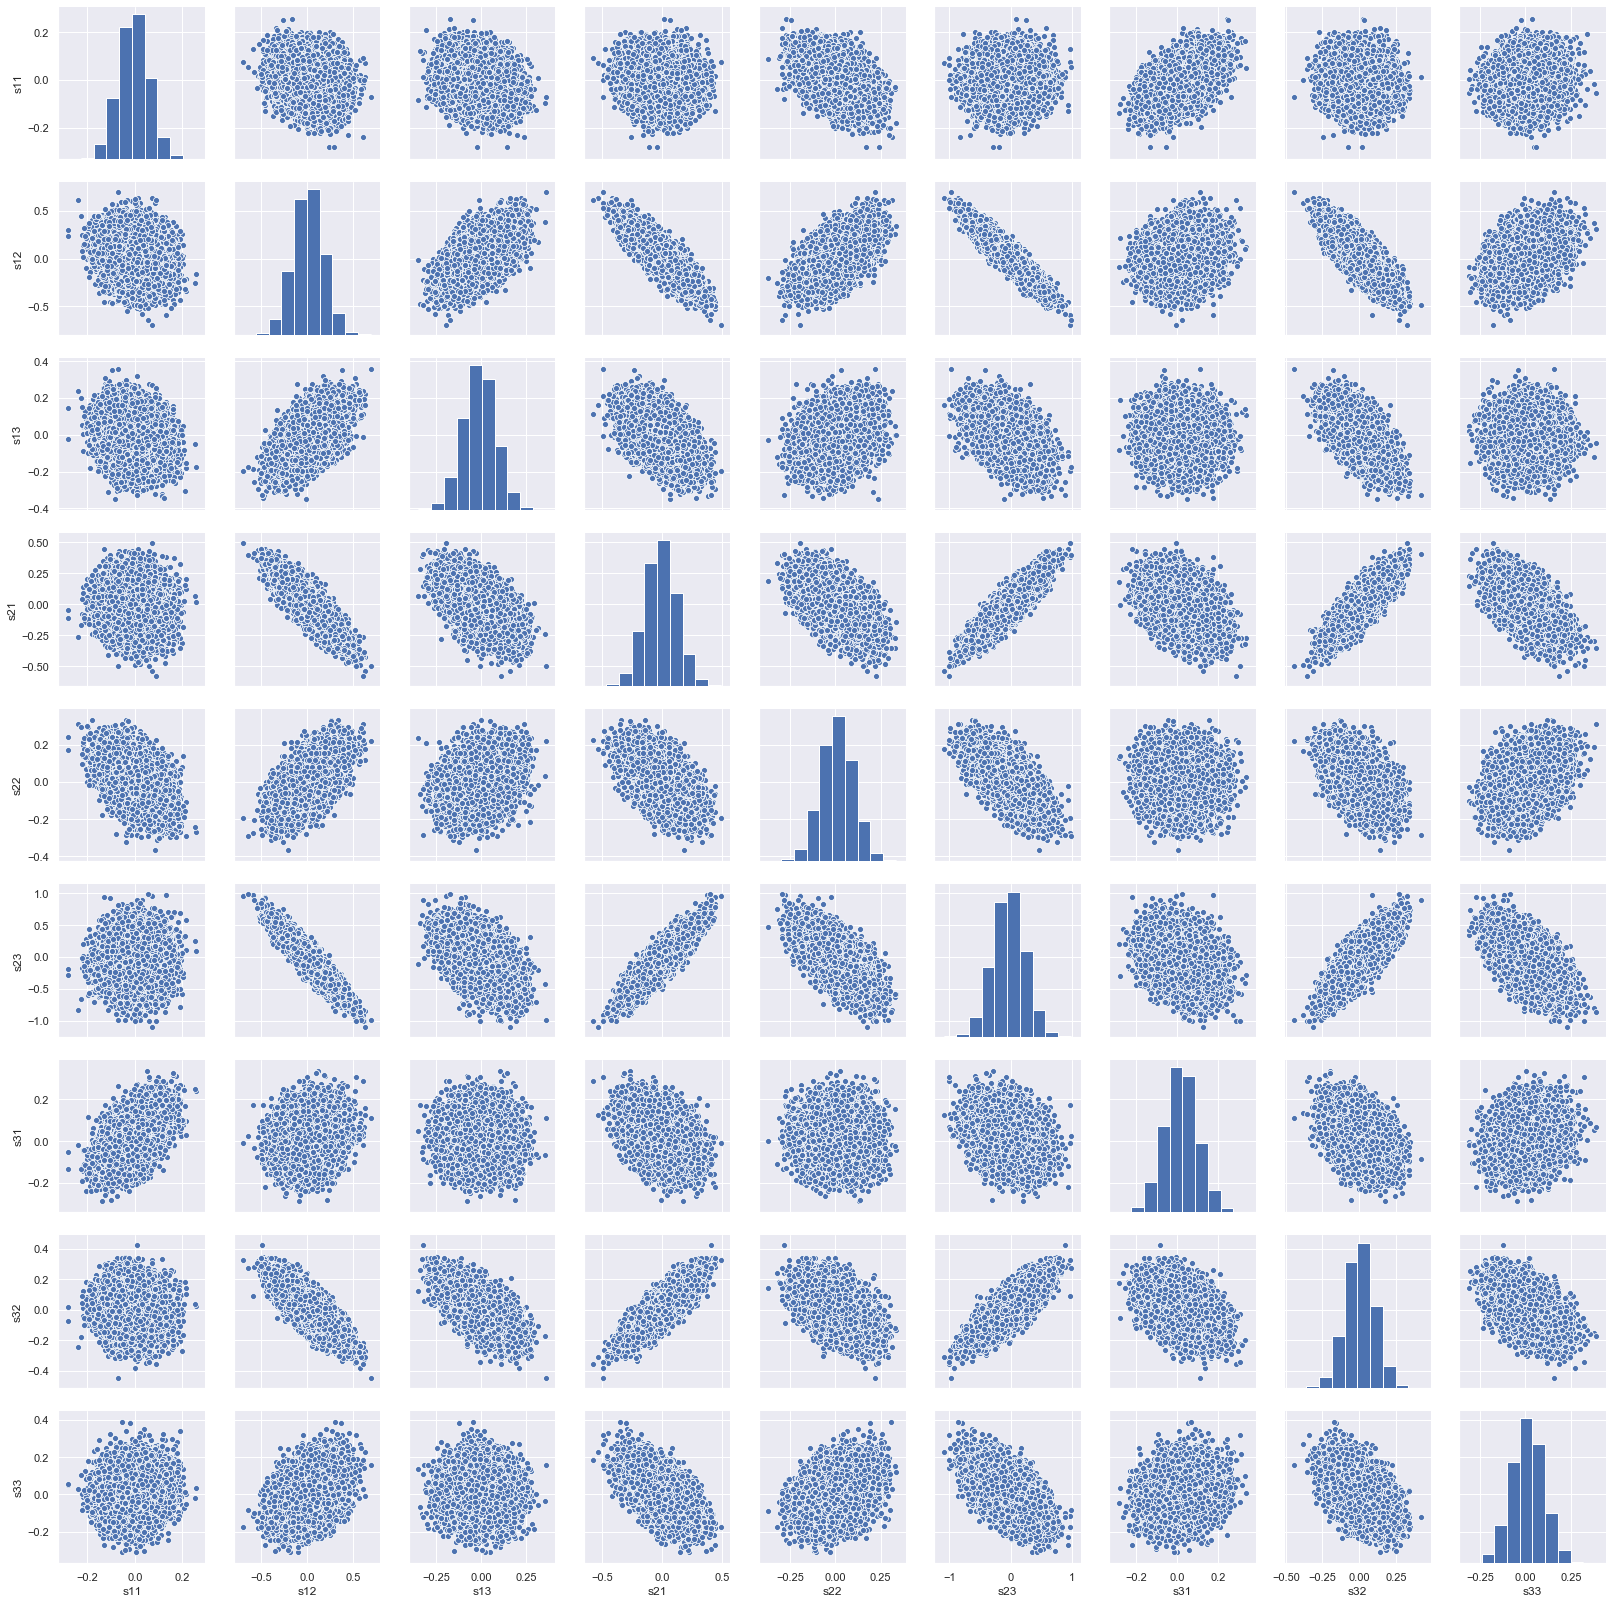

In [71]:
sns.pairplot(sample)